In [1]:
import sys
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import json 
import scanpy as sc 
from PIL import Image
import cv2
from shapely import geometry
from shapely.geometry import Polygon


current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)

sys.path.append(os.path.join(parent, 'iStar'))
from iStar.utils import load_pickle

from thor.utils import get_scalefactors, get_adata_layer_array
from thor.utils import get_region

In [2]:
with open("ROIs_no_margin.json", 'r') as f:
    ROIs = json.load(f)

In [3]:
xen_data_path = "../xenium_processed_matching_visium_genes.h5ad"
thor_data_path = "../thor-data-in-situ/fineST_BC_10x_50/fineST_geom1.0_snn0.1_trans1.0_reg_20.h5ad" 
istar_data_path = "../iStar/data/BC_0.25/cnts-super"
bayes_data_path = "../BayesSpace/bc_enhanced.h5ad"
tesla_data_path = "../TESLA/results-res50/BC_10x_30_spots_enhanced.h5ad"

im = Image.open("../iStar/data/BC_0.25/he-raw.tiff")
print(im.size)
ad_xen = sc.read_h5ad(xen_data_path)
ad_thor = sc.read_h5ad(thor_data_path)
ad_bayes = sc.read_h5ad(bayes_data_path)
ad_tesla = sc.read_h5ad(tesla_data_path)

(27587, 20511)


In [4]:
spot_data_path = "../thor-data-in-situ/BC_10x_spots.h5ad"
ad_spot = sc.read_h5ad(spot_data_path)

In [ ]:
# For scanpy visualization
ad_bayes.obs['spatial.cluster'] = ad_bayes.obs['spatial.cluster'].map(lambda x: 'C'+str(int(x)))
ad_bayes.obsm['spatial'] = ad_bayes.obs[['imagerow', 'imagecol']].values
ad_bayes.uns['spatial'] = ad_spot.uns['spatial']

In [6]:
def rescale(value, scalefactor):
    return int(np.round(value*scalefactor))

def resize_array(arr, target_shape, interpolation=cv2.INTER_LINEAR):
    import cv2
    return cv2.resize(arr, target_shape, interpolation=interpolation) 

def get_downscaled_im(gene_array, scalefactor, locs, image_size):
    xmin, ymin = 1, 1
    xmax, ymax = image_size

    grid_sizes = (rescale(ymax, scalefactor), rescale(xmax, scalefactor))
    grid_values = np.zeros(grid_sizes)

    # Populate the grid with values from the spatial data
    x = locs[:, 0]
    y = locs[:, 1]

    col_index = np.digitize(x, np.linspace(xmin, xmax, grid_sizes[1])).astype(int)
    row_index = np.digitize(y, np.linspace(ymin, ymax, grid_sizes[0])).astype(int)

    # Assign the value to the corresponding grid cell
    grid_values[row_index - 1, col_index - 1] += gene_array[:, 0]

    grid_values[grid_values < 0] = 0
    return grid_values

def get_downscaled_roi_im_istar(gene, scalefactor, roi=None, data_path=istar_data_path):
    cnts = load_pickle(f'{data_path}/{gene}.pickle')
    if roi is None:
        return cnts
    roi_downscale = (rescale(roi[0], scalefactor), rescale(roi[2], scalefactor), rescale(roi[1], scalefactor), rescale(roi[3], scalefactor))
    istar_gene_cnts_roi = cnts[roi_downscale[1]:roi_downscale[3], roi_downscale[0]:roi_downscale[2]]
    return istar_gene_cnts_roi  
    
def get_downscaled_roi_im_tesla(gene, ad, image_size, roi=None, res=50):
    gene_array = get_adata_layer_array(ad[:, gene])
    scalefactor_tesla = 1/res
    scalefactor = get_scalefactors(ad)['tissue_hires_scalef']
    locs = ad.obsm['spatial']
    
    grid_values = get_downscaled_im(gene_array, scalefactor_tesla, locs, image_size)
    target_size = (rescale(image_size[0], scalefactor), rescale(image_size[1], scalefactor))
    grid_values = resize_array(grid_values, target_size)

    if roi is None:
        return grid_values
    
    roi_downscale = (rescale(roi[2], scalefactor), rescale(roi[3], scalefactor), rescale(roi[0], scalefactor), rescale(roi[1], scalefactor))
    gene_mat_roi = grid_values[roi_downscale[0]: roi_downscale[1], roi_downscale[2]:roi_downscale[3]]
    
    return gene_mat_roi

def get_nearest_neighbors(ad, n_neighbors=2):
    from sklearn.neighbors import NearestNeighbors
    locs = ad.obsm['spatial']
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(locs)
    distances, indices = nbrs.kneighbors(locs)
    return np.mean(distances[:, -1])

def get_downscaled_roi_im_bayes(gene, ad, image_size, roi=None):
    gene_array = get_adata_layer_array(ad[:, gene])
    scalefactor = get_scalefactors(ad)['tissue_hires_scalef']
    locs = ad.obsm['spatial']
    spotpixelsize = get_nearest_neighbors(ad, 2)
    print(f"{spotpixelsize}^2 pixels per spot")
    bayes_arr = get_im_bayes(gene_array, locs, image_size, spotpixelsize)

    downscale_size = (rescale(image_size[0], scalefactor), rescale(image_size[1], scalefactor))
    grid_values = resize_array(bayes_arr, downscale_size)

    if roi is None:
        return grid_values
    
    roi_downscale = (rescale(roi[2], scalefactor), rescale(roi[3], scalefactor), rescale(roi[0], scalefactor), rescale(roi[1], scalefactor))
    gene_mat_roi = grid_values[roi_downscale[0]: roi_downscale[1], roi_downscale[2]:roi_downscale[3]]
    
    return gene_mat_roi

def get_im_bayes(gene_array, locs, image_size, spotpixelsize):

    pixels_half_side = int(np.floor(spotpixelsize*0.5))
    xmin, ymin = 1, 1
    xmax, ymax = image_size

    grid_sizes = (ymax, xmax)
    grid_values = np.zeros(grid_sizes)

    # Populate the grid with values from the spatial data
    x = locs[:, 0]
    y = locs[:, 1]

    # center pixels in the spot
    row_indices = np.digitize(y, np.arange(ymin, ymax))
    col_indices = np.digitize(x, np.arange(xmin, xmax))
    
    # for all other pixels in the spot
    for i in np.arange(-pixels_half_side, pixels_half_side):
        for j in np.arange(-pixels_half_side, pixels_half_side):
            row_index = row_indices + i
            col_index = col_indices + j
            grid_values[row_index - 1, col_index - 1] += gene_array[:, 0]

    grid_values[grid_values < 0] = 0
    return grid_values

def get_downscaled_roi_im(gene, ad, image_size, roi=None):
    gene_array = get_adata_layer_array(ad[:, gene])
    scalefactor = get_scalefactors(ad)['tissue_hires_scalef']
    locs = ad.obsm['spatial']
    
    grid_values = get_downscaled_im(gene_array, scalefactor, locs, image_size)

    if roi is None:
        return grid_values
    
    roi_downscale = (rescale(roi[2], scalefactor), rescale(roi[3], scalefactor), rescale(roi[0], scalefactor), rescale(roi[1],scalefactor))
    gene_mat_roi = grid_values[roi_downscale[0]: roi_downscale[1], roi_downscale[2]:roi_downscale[3]]
    
    return gene_mat_roi

def rmse(x0, x):
    return np.linalg.norm(x - x0) / np.sqrt(len(x0))

def compare_rmse(xen_gene_roi, thor_gene_roi, istar_gene_cnts_roi):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    scaler = MinMaxScaler()
    xen_gene_roi_norm = scaler.fit_transform(xen_gene_roi.ravel()[:, None])[:,0]
    istar_gene_cnts_roi_norm = scaler.fit_transform(istar_gene_cnts_roi.ravel()[:, None])[:,0]
    thor_gene_roi_norm = scaler.fit_transform(thor_gene_roi.ravel()[:, None])[:,0]
    thor_error = rmse(xen_gene_roi_norm, thor_gene_roi_norm) 
    istar_error = rmse(xen_gene_roi_norm, istar_gene_cnts_roi_norm)
    return thor_error, istar_error

## Mask the images to the same dimension

In [27]:
%%script echo skip
# pip install rasterio
import rasterio.features

# keep regions where we have visium coverage
rect = cv2.minAreaRect(ad_spot.obsm['spatial'].astype(int))
box = cv2.boxPoints(rect)
box = np.int0(box)
bbox = Polygon(box)
ad_xen_intersect = get_region(ad_xen, bbox)

# keep regions where we also have xenium coverage
rect2 = cv2.minAreaRect(ad_xen_intersect.obsm['spatial'].astype(int))
box2 = cv2.boxPoints(rect2)
box2 = np.int0(box2)
 
image_size = im.size
ad = ad_xen
scalefactor = get_scalefactors(ad)['tissue_hires_scalef']
bbox2 = Polygon(box2 * scalefactor)

xmin, ymin = 1, 1
xmax, ymax = image_size
grid_sizes = (rescale(ymax, scalefactor), rescale(xmax, scalefactor))
mask = rasterio.features.rasterize([bbox2], out_shape=grid_sizes)

Image.fromarray(mask.astype(bool)).save("visium-xenium-common-mask_hires.png")

skip


In [28]:
%%script echo skip
# pip install rasterio
import rasterio.features

spot_data_path = "BC_10x_spots.h5ad"
ad_spot = sc.read_h5ad(spot_data_path)

# keep regions where we have visium coverage
rect = cv2.minAreaRect(ad_spot.obsm['spatial'].astype(int))
box = cv2.boxPoints(rect)
box = np.int0(box)

image_size = im.size
scalefactor = get_scalefactors(ad_spot)['tissue_hires_scalef']
bbox = Polygon(box * scalefactor)

xmin, ymin = 1, 1
xmax, ymax = image_size
grid_sizes = (rescale(ymax, scalefactor), rescale(xmax, scalefactor))
mask = rasterio.features.rasterize([bbox], out_shape=grid_sizes)

Image.fromarray(mask.astype(bool)).save("visium-mask_hires.png")

skip


### Save iStar data as images using the provided mask.

In [ ]:
%%capture
from iStar.utils import load_image
from iStar.plot_imputed import plot_super

mask = load_image(f'visium-mask_hires.png') > 0

output_dir = "ExpressionImages_visium-mask_hires"
istar_output_dir = os.path.join(output_dir, "iStar")

os.makedirs(istar_output_dir, exist_ok=True)

for gene in ad_xen.var_names:
    cnts = load_pickle(f'{istar_data_path}/{gene}.pickle')
    cnts = cnts[1:, :]
    cnts[~mask] = np.nan
    plot_super(cnts, os.path.join(istar_output_dir, f'{gene}.png'))

### Save Xenium data as images using the provided mask.

In [ ]:
%%capture
from iStar.utils import load_image
from iStar.plot_imputed import plot_super

mask = load_image(f'visium-mask_hires.png') > 0

output_dir = "ExpressionImages_visium-mask_hires"
xen_output_dir = os.path.join(output_dir, "Xenium")
os.makedirs(xen_output_dir, exist_ok=True)

for gene in ad_xen.var_names:
    xen_gene_roi = get_downscaled_roi_im(gene, ad_xen, im.size)
    xen_gene_roi[~mask] = np.nan
    plot_super(xen_gene_roi, os.path.join(xen_output_dir, f'{gene}.png'))

### Save Thor data as images using the provided mask.

In [ ]:
%%capture
from iStar.utils import load_image
from iStar.plot_imputed import plot_super

mask = load_image(f'visium-mask_hires.png') > 0

output_dir = "ExpressionImages_visium-mask_hires"
thor_output_dir = os.path.join(output_dir, "Thor")
os.makedirs(thor_output_dir, exist_ok=True)

for gene in ad_xen.var_names:
    thor_gene_roi = get_downscaled_roi_im(gene, ad_thor, im.size)
    thor_gene_roi[~mask] = np.nan
    thor_gene_roi[thor_gene_roi<0] = 0
    plot_super(thor_gene_roi, os.path.join(thor_output_dir, f'{gene}.png'))

### Save BayesSpace data as images using the provided mask.

In [100]:
%%capture
from iStar.utils import load_image
from iStar.plot_imputed import plot_super

mask = load_image(f'visium-mask_hires.png') > 0

output_dir = "ExpressionImages_visium-mask_hires"
bayes_output_dir = os.path.join(output_dir, "BayesSpace")
os.makedirs(bayes_output_dir, exist_ok=True)

for gene in ad_xen.var_names:
    bayes_gene_roi = get_downscaled_roi_im_bayes(gene, ad_bayes, im.size)
    bayes_gene_roi[~mask] = np.nan
    bayes_gene_roi[bayes_gene_roi<0] = 0
    plot_super(bayes_gene_roi, os.path.join(bayes_output_dir, f'{gene}.png'))

### Save TESLA data as images using the provided mask.

In [235]:
%%capture
from iStar.utils import load_image
from iStar.plot_imputed import plot_super

mask = load_image(f'visium-mask_hires.png') > 0

output_dir = "ExpressionImages_visium-mask_hires"
tesla_output_dir = os.path.join(output_dir, "Tesla")
os.makedirs(tesla_output_dir, exist_ok=True)

for gene in ad_xen.var_names:
    tesla_gene_roi = get_downscaled_roi_im_tesla(gene, ad_tesla, im.size, res=50)
    tesla_gene_roi[~mask] = np.nan
    tesla_gene_roi[tesla_gene_roi<0] = 0
    plot_super(tesla_gene_roi, os.path.join(tesla_output_dir, f'{gene}.png'))

In [209]:
mask.shape

(1487, 2000)

## Compare methods using CW-SSIM 

In [8]:
from ssim import SSIM
from ssim.utils import get_gaussian_kernel

In [9]:
output_dir = "ExpressionImages_visium-mask_hires"
istar_output_dir = os.path.join(output_dir, "iStar")
xen_output_dir = os.path.join(output_dir, "Xenium")
thor_output_dir = os.path.join(output_dir, "Thor")
bayes_output_dir = os.path.join(output_dir, "BayesSpace")
tesla_output_dir = os.path.join(output_dir, "Tesla")

def get_cwssim(gene):
    xen_image_path = os.path.join(xen_output_dir, f'{gene}.png')
    thor_image_path = os.path.join(thor_output_dir, f'{gene}.png')
    istar_image_path = os.path.join(istar_output_dir, f'{gene}.png')
    bayes_image_path = os.path.join(bayes_output_dir, f'{gene}.png')
    tesla_image_path = os.path.join(tesla_output_dir, f'{gene}.png')
    
    xen_image = Image.open(xen_image_path).convert('L')
    thor_image = Image.open(thor_image_path).convert('L')
    istar_image = Image.open(istar_image_path).convert('L')
    bayes_image = Image.open(bayes_image_path).convert('L')
    tesla_image = Image.open(tesla_image_path).convert('L')

    ssim = SSIM(xen_image)
    ssim_thor = ssim.cw_ssim_value(thor_image)
    ssim_istar = ssim.cw_ssim_value(istar_image)
    ssim_bayes = ssim.cw_ssim_value(bayes_image)
    ssim_tesla = ssim.cw_ssim_value(tesla_image)
    
    return ssim_thor, ssim_istar, ssim_bayes, ssim_tesla

In [14]:
get_cwssim('ABCC11')

(0.7197613267443947,
 0.5868532185704673,
 0.6446836561780466,
 0.5608224367306082)

In [239]:
get_cwssim('ERBB2')

(0.730451885082443, 0.5843596020544767, 0.6665266003320757, 0.6157533413651725)

In [214]:
get_cwssim('AGR3')

(0.6828679913578447,
 0.5872242962672882,
 0.6755297854154156,
 0.6261076048576839)

In [ ]:
ssim_array = np.zeros((len(ad_xen.var_names), 2))

from tqdm import tqdm

for i, gene in tqdm(enumerate(ad_xen.var_names)):
    #print(gene, end="\t")
    ssim_array[i] = get_cwssim(gene)
    #print(ssim_array[i])

In [ ]:
df = pd.DataFrame(index=ad_xen.var_names, columns=['Thor', 'iStar', 'BayesSpace', 'TESLA'])

df['Thor'] = ssim_array[:, 0]
df['iStar'] = ssim_array[:, 1]
df['BayesSpace'] = ssim_array[:, 2]
df['Tesla'] = ssim_array[:, 3]

df

,Thor,iStar,BayesSpace,Tesla
Gene,,,,
ABCC11,0.719761,0.586853,0.644684,0.560822
ACTA2,0.737250,0.588407,0.650360,0.601830
ACTG2,0.693789,0.594008,0.683976,0.647027
ADAM9,0.739363,0.580346,0.640348,0.595762
ADGRE5,0.731257,0.574575,0.635518,0.579375
...,...,...,...,...
VWF,0.712352,0.560290,0.632346,0.570701
WARS,0.739740,0.580898,0.644756,0.588985
ZEB1,0.727954,0.565778,0.622956,0.593285


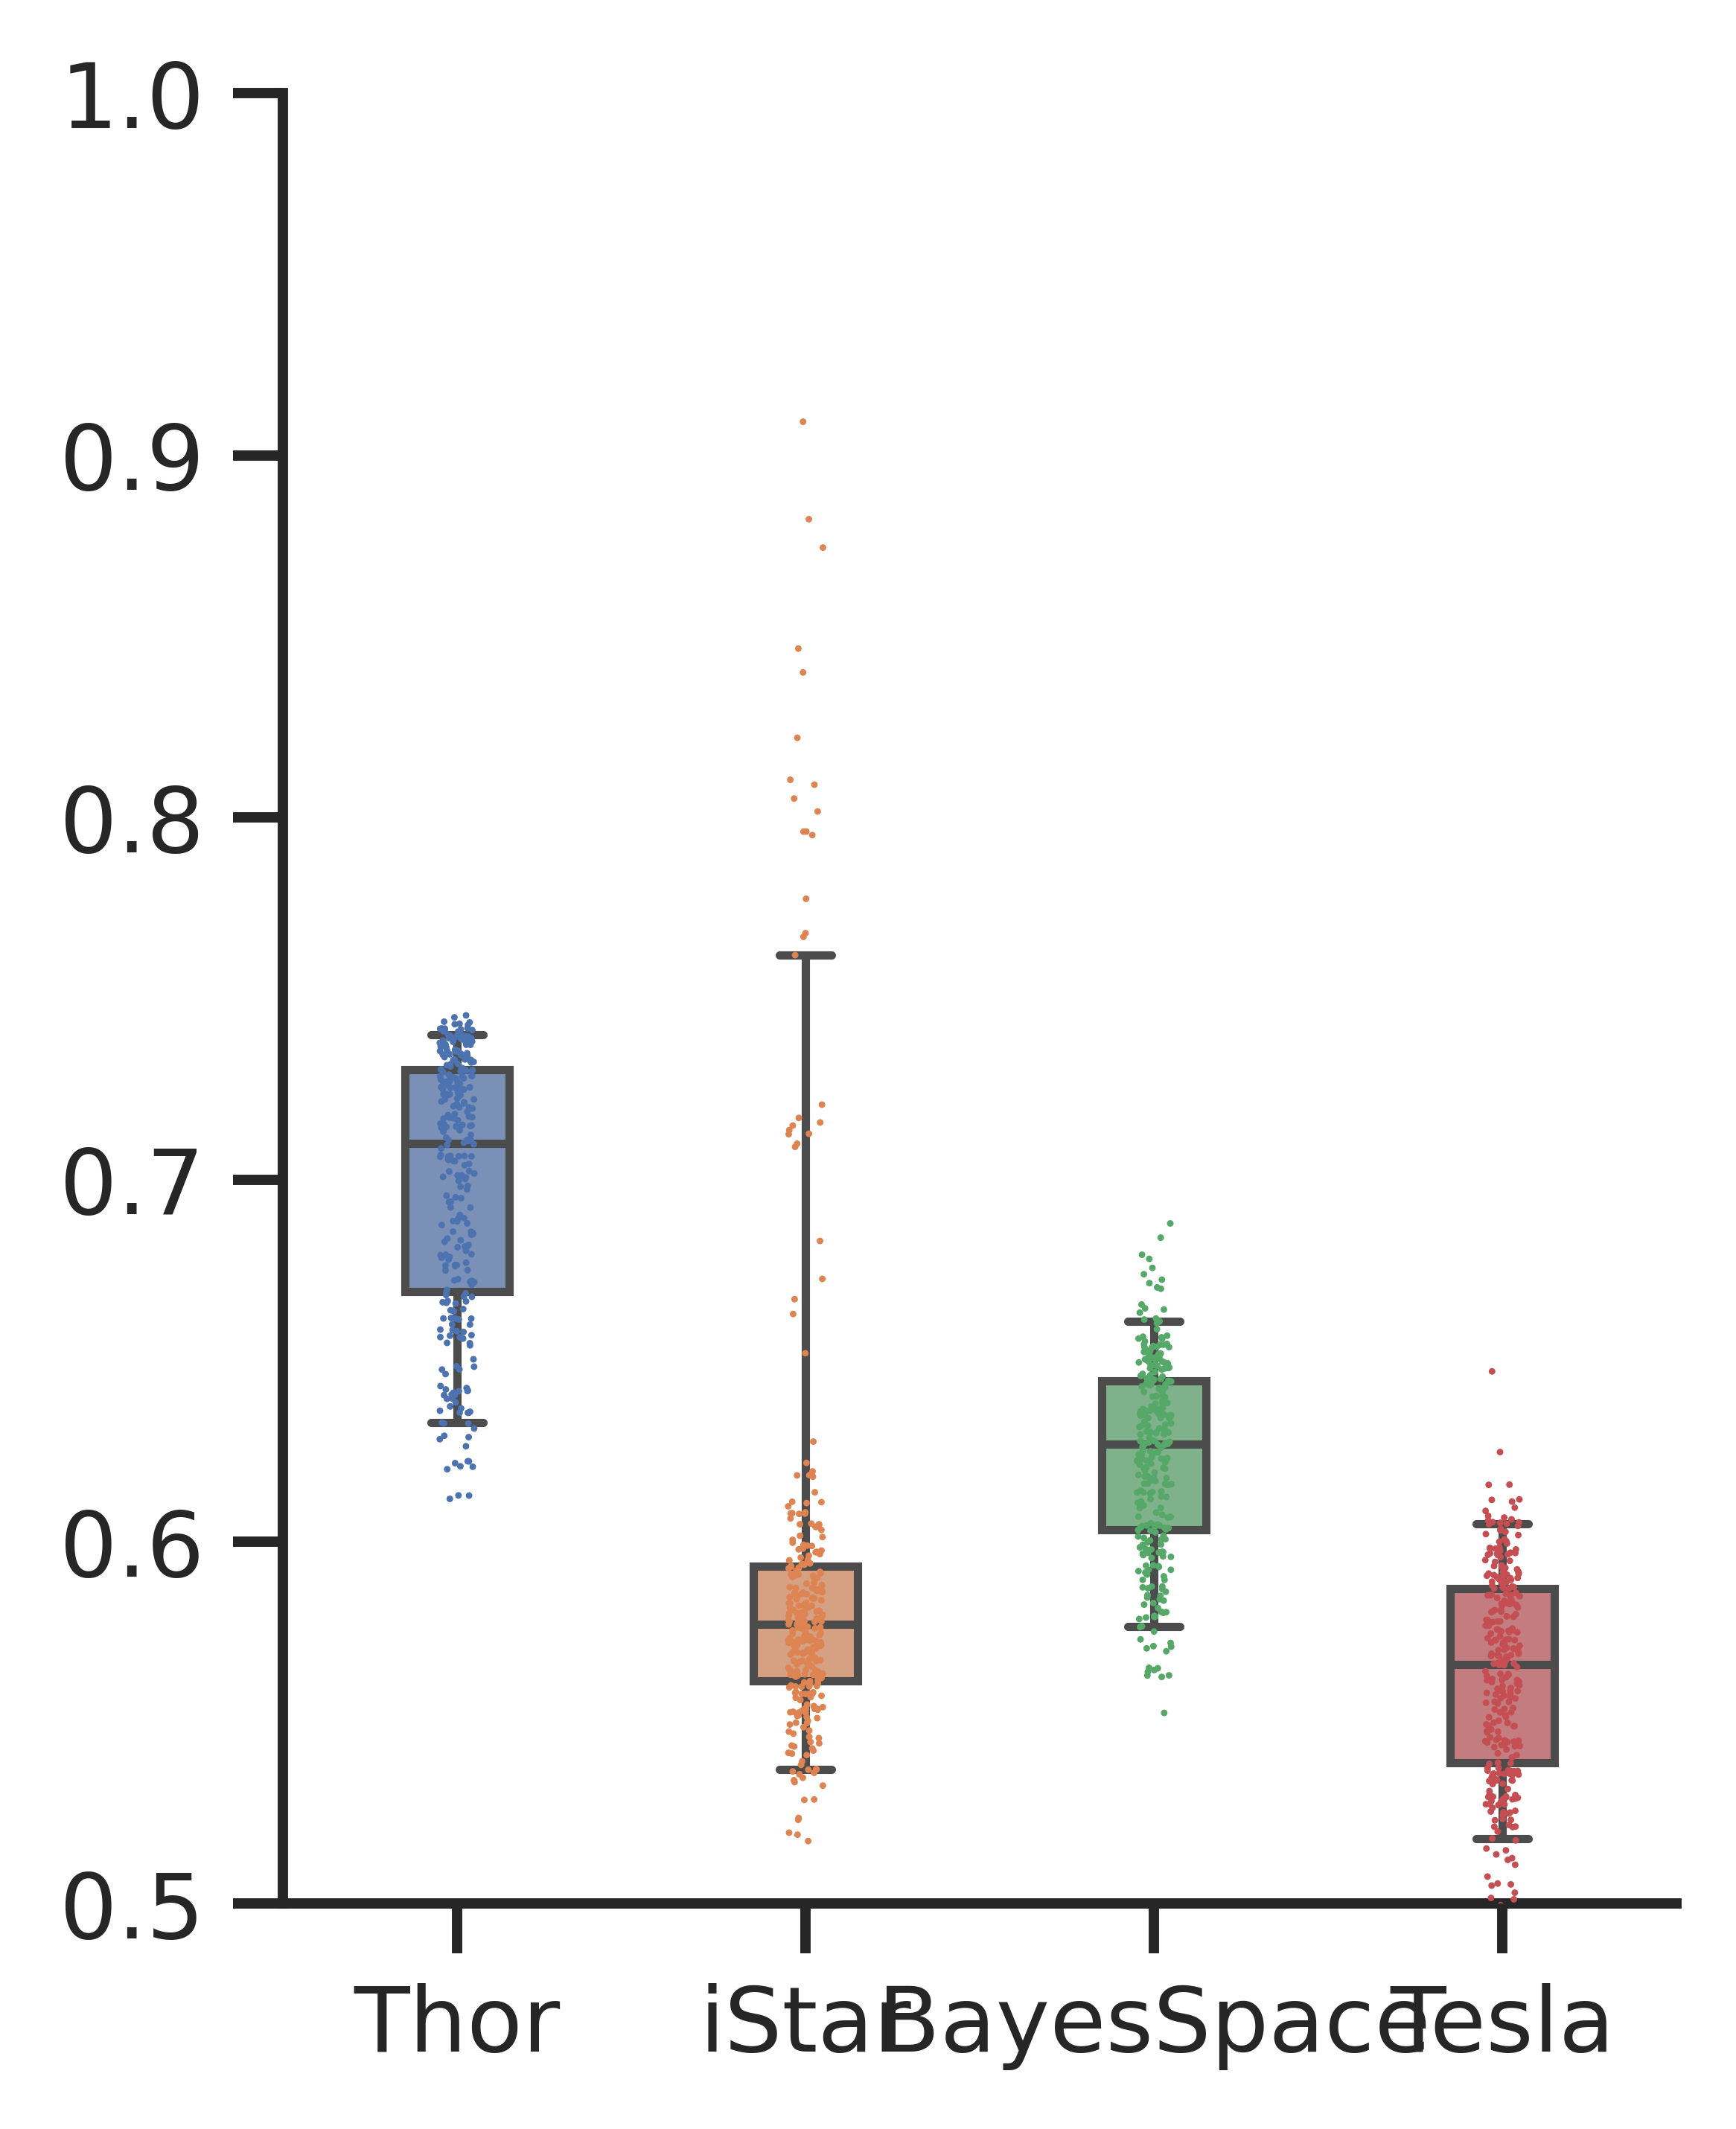

In [ ]:
# SSIM
import seaborn as sns
sns.set(font="Times New Roman")
sns.set_theme(style='ticks')


fig = plt.figure(figsize=(3,4), dpi=400)
ax = sns.boxplot(df, whis=(5,95), width=0.3, fliersize=0.)
sns.stripplot(df, size=0.8, jitter=0.05, dodge=False, legend="", alpha=1, ax=ax)

ax.set_ylim(0.5, 1)
ax.spines.right.set_color('none')
ax.spines.top.set_color('none')
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
fig.savefig("Similarity.pdf")

In [114]:
from scipy.stats import mannwhitneyu

pval = mannwhitneyu(df['Thor'], df['iStar'], alternative="greater")
pval.pvalue

4.6656243247218844e-74

In [115]:
from scipy.stats import mannwhitneyu

pval = mannwhitneyu(df['Thor'], df['BayesSpace'], alternative="greater")
pval.pvalue

1.1585092074839228e-78

## Compare methods using RMSE

In [ ]:
output_dir = "ExpressionImages_visium-mask_hires"
istar_output_dir = os.path.join(output_dir, "iStar")
xen_output_dir = os.path.join(output_dir, "Xenium")
thor_output_dir = os.path.join(output_dir, "Thor")
bayes_output_dir = os.path.join(output_dir, "BayesSpace")
tesla_output_dir = os.path.join(output_dir, "Tesla")

from sklearn.metrics import mean_squared_error

def get_rmse_norm(gene):
    xen_image_path = os.path.join(xen_output_dir, f'{gene}.png')
    thor_image_path = os.path.join(thor_output_dir, f'{gene}.png')
    istar_image_path = os.path.join(istar_output_dir, f'{gene}.png')
    bayes_image_path = os.path.join(bayes_output_dir, f'{gene}.png')
    tesla_image_path = os.path.join(tesla_output_dir, f'{gene}.png')
    
    xen_image = np.array(Image.open(xen_image_path).convert('L'))
    thor_image = np.array(Image.open(thor_image_path).convert('L'))
    istar_image = np.array(Image.open(istar_image_path).convert('L'))
    bayes_image = np.array(Image.open(bayes_image_path).convert('L'))
    tesla_image = np.array(Image.open(tesla_image_path).convert('L'))

    mean_xen = np.mean(xen_image)
    rmse_thor = mean_squared_error(thor_image, xen_image, squared=False) / mean_xen
    rmse_istar = mean_squared_error(istar_image, xen_image, squared=False) /mean_xen
    rmse_bayes = mean_squared_error(bayes_image, xen_image, squared=False) /mean_xen
    rmse_tesla = mean_squared_error(tesla_image, xen_image, squared=False) /mean_xen
    
    return rmse_thor, rmse_istar, rmse_bayes, rmse_tesla

In [19]:
for gene in df.index:
    df.loc[gene,  ["rmse_Thor", "rmse_iStar", "rmse_bayes", "rmse_tesla"]] = get_rmse_norm(gene)

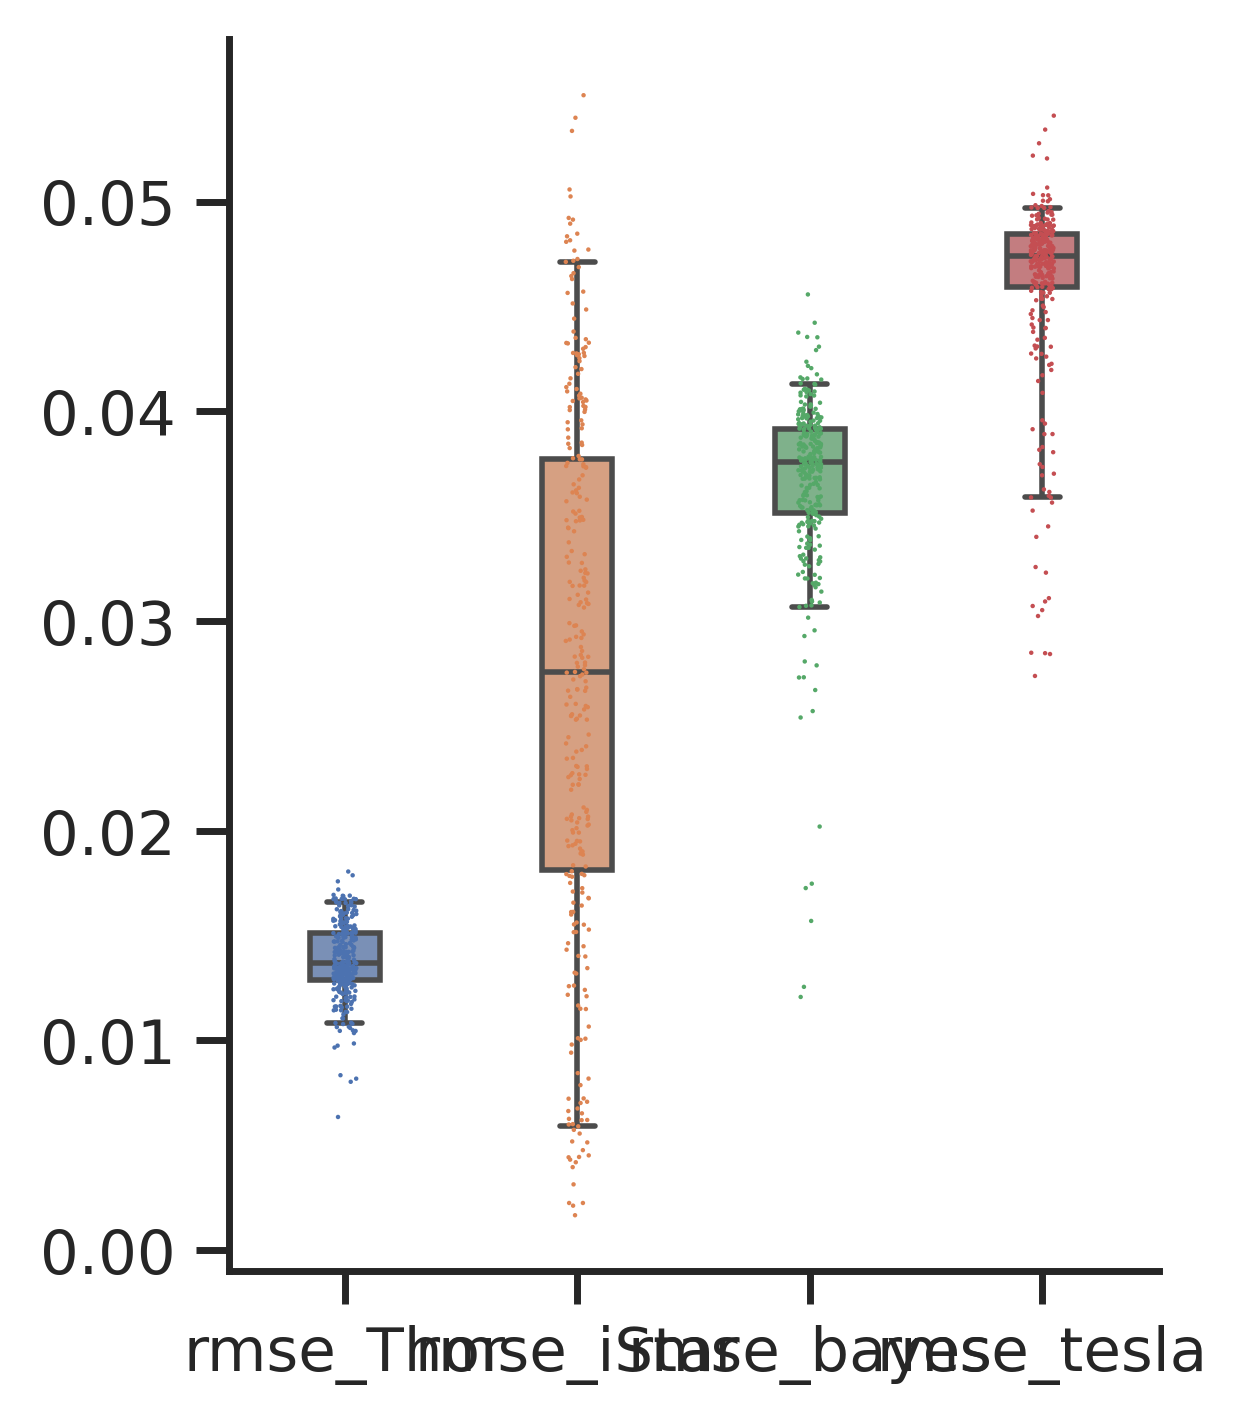

In [ ]:
# RMSE
import seaborn as sns
sns.set(font="Times New Roman")
sns.set_theme(style='ticks')

columns = ['rmse_Thor', 'rmse_iStar', 'rmse_bayes', 'rmse_tesla']
fig = plt.figure(figsize=(3,4), dpi=400)
ax = sns.boxplot(df[columns], whis=(5,95), width=0.3, fliersize=0.)
sns.stripplot(df[columns], size=0.8, jitter=0.05, dodge=False, legend="", alpha=1, ax=ax)

#ax.set_ylim(0.5, 1)
ax.spines.right.set_color('none')
ax.spines.top.set_color('none')
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
#fig.savefig("RMSE.pdf")

In [138]:
from scipy.stats import mannwhitneyu

pval = mannwhitneyu(df['rmse_Thor'], df['rmse_iStar'], alternative="less")
pval.pvalue

3.286564680383276e-47

In [142]:
from scipy.stats import mannwhitneyu

pval = mannwhitneyu(df['rmse_Thor'], df['rmse_bayes'], alternative="less")
pval.pvalue

1.364489403174676e-99